# DOME Human Evaluation Analysis

Analysis of the results from `evaluation_results.tsv` comparison Human (A) vs Copilot (B).

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Style
sns.set_theme(style="whitegrid")

# Load data
df = pd.read_csv('evaluation_results.tsv', sep='\t')
print(f"Total evaluations: {len(df)}")
df.head()

Total evaluations: 248


,PMCID,Field,Value_A_Human,Value_B_Copilot,Rank,Comment,Timestamp
0,PMC10716825,publication/title,MLcps: machine learning cumulative performance...,MLcps: machine learning cumulative performance...,Tie_High,Full stop in copilot annotations - unnecessary,2026-01-28T18:21:52.041977
1,PMC10716825,publication/authors,"Akshay Akshay, Masoud Abedi, Navid Shekarchiza...","Akshay Akshay, Abedi Masoud, Shekarchizadeh Na...",Tie_High,NAme order difference - must specifcy preferre...,2026-01-28T18:21:54.627295
2,PMC10716825,publication/journal,GigaScience,GigaScience,Tie_High,NaN,2026-01-28T18:21:55.800229
3,PMC10716825,publication/year,2023,2022,A_Better,Wrong year extraction - 2022 correct,2026-01-28T18:21:59.161497
4,PMC10716825,publication/doi,10.1093/gigascience/giad108,10.1093/gigascience/giad108,Tie_High,NaN,2026-01-28T18:22:29.095698


## Overall Results Distribution

Rank
B_Better    121
Tie_High     59
Tie_Low      41
A_Better     27
Name: count, dtype: int64


/tmp/ipykernel_312962/1883087678.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Rank', order=['A_Better', 'B_Better', 'Tie_High', 'Tie_Low'], palette='viridis')


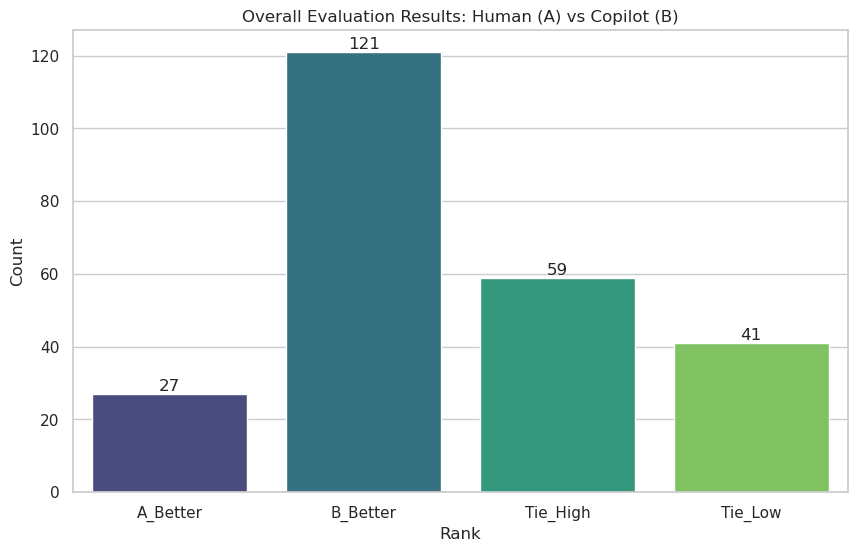

In [7]:
# Count Ranks
rank_counts = df['Rank'].value_counts()
print(rank_counts)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Rank', order=['A_Better', 'B_Better', 'Tie_High', 'Tie_Low'], palette='viridis')
plt.title('Overall Evaluation Results: Human (A) vs Copilot (B)')
plt.ylabel('Count')

# Add labels
for container in ax.containers:
    ax.bar_label(container)

plt.show()

## Win Rate Analysis
Aggregating 'Tie_High' and 'Tie_Low' into a single 'Tie' category to compare win rates.

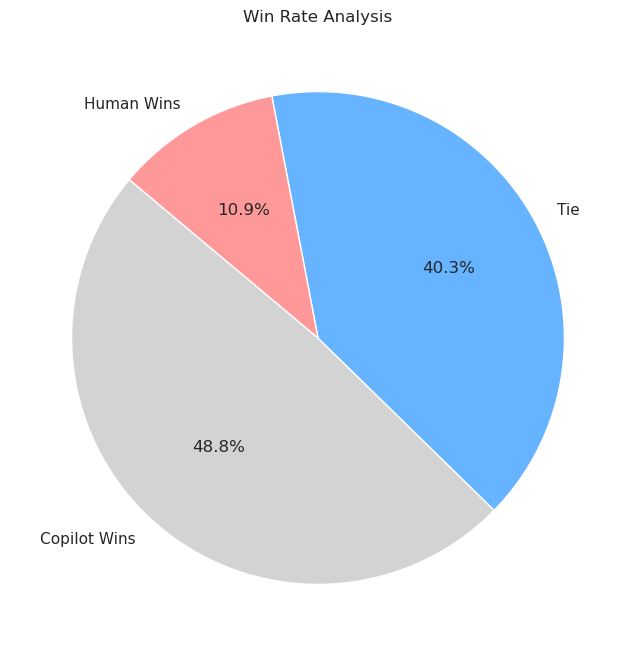

In [8]:
def categorize_result(rank):
    if rank == 'A_Better': return 'Human Wins'
    if rank == 'B_Better': return 'Copilot Wins'
    return 'Tie'

df['Outcome'] = df['Rank'].apply(categorize_result)

outcome_counts = df['Outcome'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgray', '#66b3ff', '#ff9999'])
plt.title('Win Rate Analysis')
plt.show()

## Performance by Field
Which fields does Copilot struggle with compared to Human?

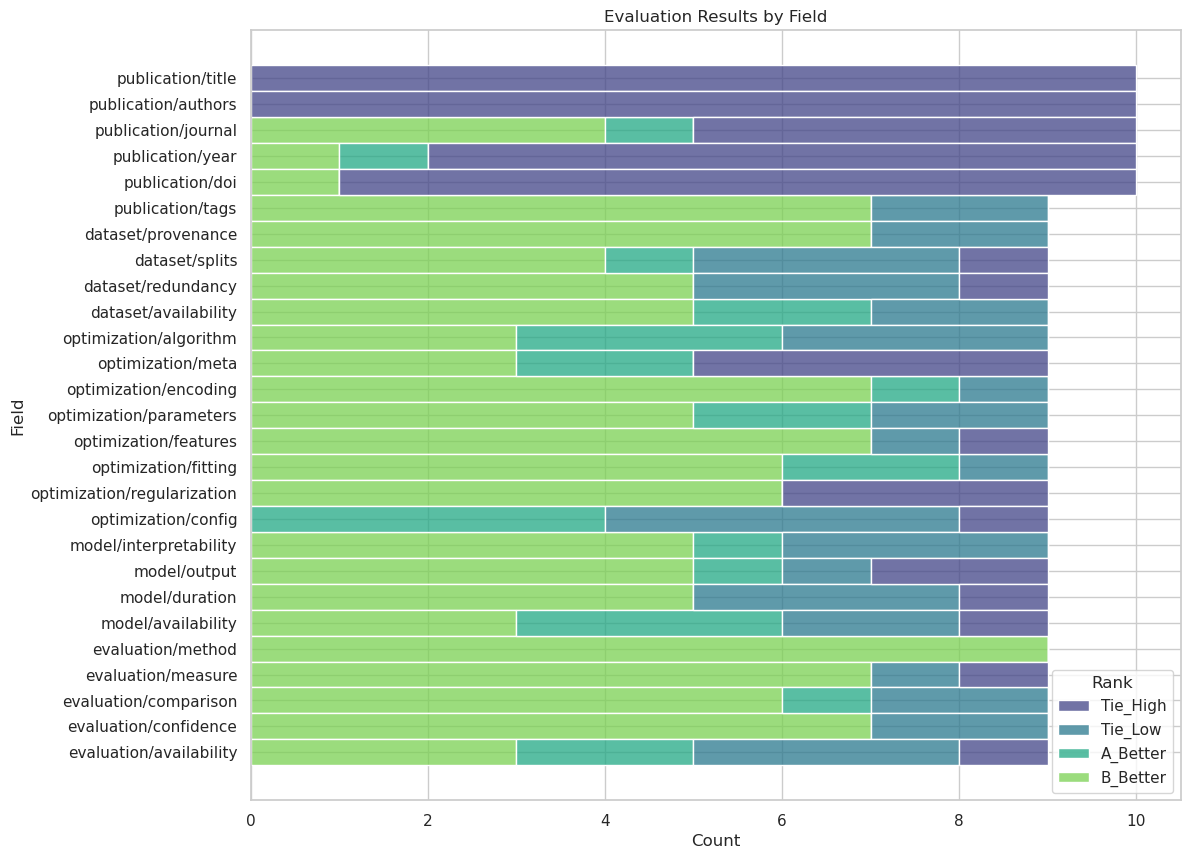

In [9]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, y='Field', hue='Rank', multiple='stack', hue_order=['Tie_High', 'Tie_Low', 'A_Better', 'B_Better'], palette='viridis')
plt.title('Evaluation Results by Field')
plt.xlabel('Count')
plt.show()

## Copilot Win Rate per Field
Calculating the percentage of times Copilot (B) was rated better than Human (A) for each field.

/tmp/ipykernel_312962/743422158.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=field_stats['Copilot_Win_Rate'], y=field_stats.index, palette='Blues_r')


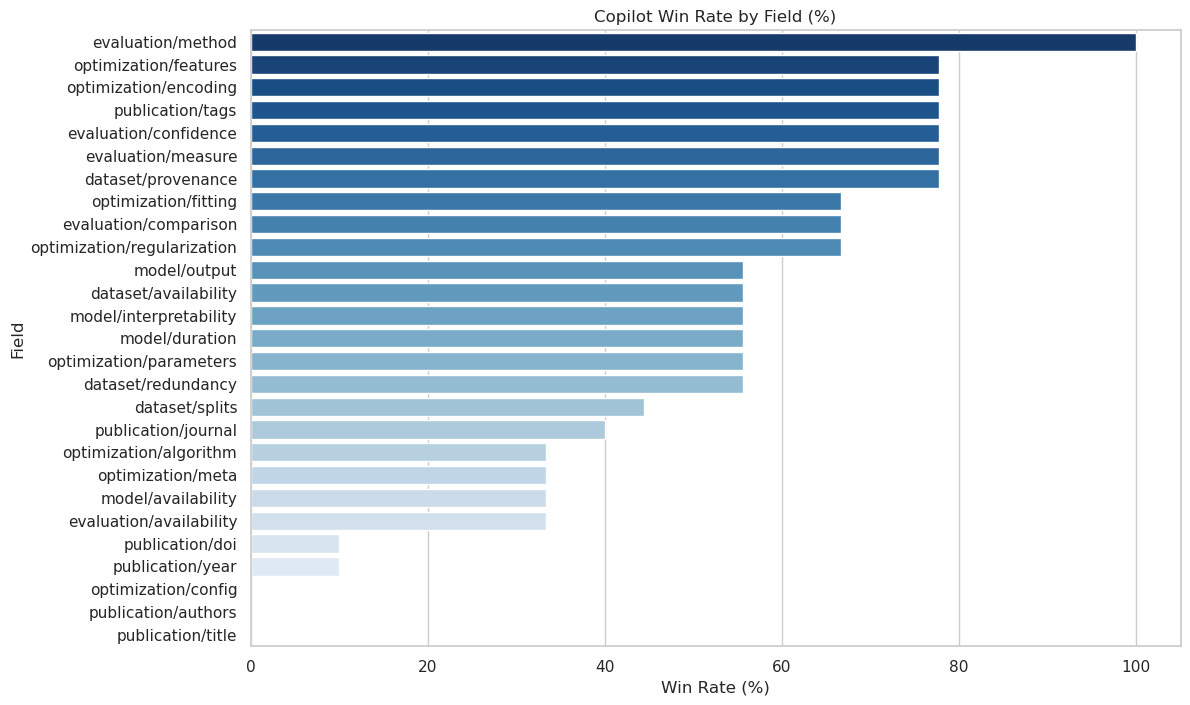

In [10]:
# Calculate B_Better percentage per field
field_stats = df.groupby('Field')['Rank'].value_counts(normalize=True).unstack().fillna(0)
if 'B_Better' in field_stats.columns:
    field_stats['Copilot_Win_Rate'] = field_stats['B_Better'] * 100
else:
    field_stats['Copilot_Win_Rate'] = 0
    
field_stats = field_stats.sort_values('Copilot_Win_Rate', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=field_stats['Copilot_Win_Rate'], y=field_stats.index, palette='Blues_r')
plt.title('Copilot Win Rate by Field (%)')
plt.xlabel('Win Rate (%)')
plt.show()